# Recommender System

Blah blah blah

## Import Libraries and Define File Paths

In [24]:
import os
import glob
import json
import scipy
import random
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import threadpoolctl
from tqdm import tqdm
import warnings
from collections import defaultdict
from implicit.als import AlternatingLeastSquares as ALS
from lightfm import LightFM
from lightfm.data import Dataset
from scipy.sparse import coo_matrix
from lightfm.evaluation import precision_at_k,recall_at_k,auc_score,reciprocal_rank
from lightfm.cross_validation import random_train_test_split
from math import log2 as log
from scipy.spatial import distance
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, KFold
from surprise.prediction_algorithms.knns import KNNBasic, KNNWithMeans
from surprise.prediction_algorithms.matrix_factorization import SVD
from implicit.evaluation import (AUC_at_k,
                                 mean_average_precision_at_k,
                                 ndcg_at_k, precision_at_k)
from implicit.evaluation import train_test_split
from unidecode import unidecode

warnings.simplefilter(action='ignore', category=FutureWarning)

dir = "../dataset/utility"

if not os.path.exists(dir):
    os.mkdir(dir)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


## Define Utility Functions and Dataset Generation Functions

In [2]:
def clean_str(x):
    forbidden_chars = [',', '-', '?', '(', ')',
                       '~', '*', '.', '!']
    x = unidecode(x)
    x = '_'.join(x.replace('& ', '').split(' '))
    x = x.lower().strip()
    for c in forbidden_chars:
        x = x.replace(c, '')
    return x

def items_and_reviews_to_dataframe(json_data):
    products = []
    reviews = []
    asins = []
    asin_product_mapping = []
    for product_data in json_data:
        product = {}
        if ('body' not in product_data or 'reviews' not in product_data['body']
            or 'productInformation' not in product_data['body']):
            continue

        reviews_data = product_data['body'].get('reviews', [])
        product_name = product_data['body'].get('name', 'Unknown Product')
        product_data = product_data['body']
        asin = product_data['canonicalUrl'].split('/')[-1].lower()

        if not reviews_data or len(reviews_data) == 0:
            continue
        
        ignore = ['dimensions', 'country_of_origin', 'batteries_included',
                  'weight', 'height', 'size', 'model', 'manufacturer',
                  'specifications', 'voltage', 'volts', '12v', 'climate_pledge',
                  'capacity', 'number_of_items', 'import', 'lxwxh', 'product'
                  'included']

        product['ASIN'] = asin

        if asin not in asins:
            asin_product_mapping.append({
                'ASIN': asin,
                'name': product_name
            })
            asins.append(asin)
        breadcrumbs = product_data.get('breadCrumbs', [])
        for bc in breadcrumbs:
            name = clean_str(bc['name'])
            flag = True
            for ig in ignore:
                if ig in name:
                    flag = False
            if flag and '_' in name:
                name_list = name.split("_")
                for n in name_list:
                    product[n] = 1.0
            elif flag:
                product[name] = 1.0
        
        products.append(product)

        review = {}
        for r in reviews_data:
            review['ASIN'] = asin
            review['ProductName'] = clean_str(product_name)
            review['reviewerID'] = r['reviewerName'] + '_' + r['reviewerLink'].split('/')[-1].split('.')[-1]
            review['price'] = product_data.get('rawPrice', 0)
            reviewRating = re.findall(r'(\d+\.\d+)', r['reviewRating'])
            reviewLocation = r['reviewDate'].split('on')[0].split(' in ')[-1].replace('the ', '')
            reviewDate = re.findall(r'on (.+)$', r['reviewDate'])
            reviewVotes = re.findall(r'(\d+)', r['reviewVotes'])
            review['image'] = product_data.get('mainImage', None)
            
            if reviewRating:
                review['customerReview'] = float(reviewRating[0])
            else:
                review['customerReview'] = np.nan
            if reviewDate:
                review['reviewDate'] = reviewDate[0]
            else:
                review['reviewDate'] = 'Unknown'
            if reviewLocation:
                review['reviewLocation'] = reviewLocation
            else:
                review['reviewLocation'] = 'Unknown'
            if reviewVotes:
                review['reviewVotes'] = reviewVotes[0]
            else:
                review['reviewVotes'] = 0
            reviews.append(review)
            review = {}
    all_reviews_df = pd.DataFrame(reviews)
    all_items_df = pd.DataFrame(products)
    asins_df = pd.DataFrame(asin_product_mapping)
    return all_reviews_df, all_items_df, asins_df

def get_all_json_data():
    base_dir = '../dataset/extracts/amazon'
    all_json_data = []
    for root, dirs, files in os.walk(base_dir):
        for dir in dirs:
            items_path = os.path.join(root, dir, 'items')
            if os.path.exists(items_path):
                json_files = glob.glob(os.path.join(items_path, '*.json'))
                
                for json_file in tqdm(json_files, desc=f'Loading JSON Files in {dir}'):
                    try:
                        with open(json_file, "r") as f:
                            all_json_data.append(json.load(f))
                    except json.JSONDecodeError:
                        print(f"Error loading JSON from file {json_file}: file is empty or not a valid JSON.")
                    except Exception as e:
                        print(f"Unexpected error loading JSON from file {json_file}: {e}")
    return all_json_data

def load_dataset():
    items_df = pd.read_csv(f"{dir}/itemset_preprocessed.csv")
    items_df.set_index("ASIN", inplace=True)
 
    df_utility = pd.read_csv(f"{dir}/utility_topn.csv", index_col=0)
    df_utility.set_index("reviewerID", inplace=True)

    reviews_df = pd.read_csv(f"{dir}/reviews.csv")
    reviews_df.set_index('reviewerID', inplace=True)
    
    asins_df = pd.read_csv(f"{dir}/asin_product_mapping.csv")
    asins_df.set_index('ASIN', inplace=True)

    print(f"shape of df_utility: {df_utility.shape}")
    print(f"shape of items_df: {items_df.shape}")
    print(f"shape of asins_df: {asins_df.shape}")
    return items_df, df_utility, reviews_df, asins_df

## Generate the Dataset and Preprocess

### Fetch all json data

In [3]:
all_json_data = get_all_json_data()
all_reviews_df, all_items_df, asins_df = items_and_reviews_to_dataframe(all_json_data)
all_reviews_df = all_reviews_df.replace(np.nan, '', regex=True)
all_reviews_df.drop_duplicates(keep="first", inplace=True)
all_reviews_df.to_csv(f"{dir}/reviews.csv")
all_items_df.drop_duplicates(keep='first', inplace=True)
all_items_df.fillna(0, inplace=True)
asins_df.to_csv(f"{dir}/asin_product_mapping.csv", index=False)

Loading JSON Files in stove: 100%|██████████| 189/189 [00:00<00:00, 1395.04it/s]


Error loading JSON from file ../dataset/extracts/amazon/stove/items/amazon_B07V7JNTLB.json: file is empty or not a valid JSON.


Loading JSON Files in intel amd processor: 100%|██████████| 144/144 [00:00<00:00, 4891.79it/s]


### Preprocess itemset

In [4]:
all_items_df.reset_index(inplace=True)
vc = all_items_df['ASIN'].value_counts()
to_merge = vc.loc[lambda x: x > 1].index.tolist()

all_items_df.set_index('ASIN', inplace=True)
merge_dicts = []
for asin in to_merge:
    merged_row = all_items_df.loc[asin].sum()
    merged_row = merged_row.drop('level_0')
    d = merged_row.to_dict()
    d['ASIN'] = asin
    merge_dicts.append(d)
    all_items_df.drop(asin, inplace=True)
    
merged_df = pd.DataFrame(merge_dicts)
merged_df.set_index('ASIN', inplace=True)
all_items_df = pd.concat([all_items_df, merged_df])
all_items_df.to_csv(f"{dir}/itemset_preprocessed.csv")

### Preprocess userbase

In [5]:
user_ratings_df = all_reviews_df.drop([
    "reviewVotes", "reviewLocation", "reviewDate",
    "ProductName"], axis=1)

groupby_df = user_ratings_df.groupby('reviewerID')
freq = groupby_df.size().reset_index(name='count')
user_ratings_df = pd.merge(user_ratings_df, freq, on='reviewerID', how='left')
user_ratings_df = user_ratings_df.sort_values(['count'], ascending=False)
user_ratings_df = user_ratings_df[user_ratings_df["count"] >= 10]
topn_reviewers = pd.unique(user_ratings_df["reviewerID"])
user_ratings_df.set_index("reviewerID", inplace=True)
user_ratings_df = user_ratings_df.loc[topn_reviewers]
generic_reviewerIDs = user_ratings_df.groupby('reviewerID').count().sort_values('ASIN', ascending=False)[:8].index.tolist()
topn_reviewers = [r for r in topn_reviewers if r not in generic_reviewerIDs]
user_ratings_df = user_ratings_df.loc[topn_reviewers]

rows = []
columns = all_items_df.index.tolist()
columns.append("reviewerID")

for index, data in user_ratings_df.groupby('reviewerID'):
    row = {'reviewerID': index}
    for ind, d in data.iterrows():
        row[d['ASIN']] = d['customerReview']
    rows.append(row)

df_utility = pd.DataFrame(rows, columns=columns)
df_utility.to_csv(f"{dir}/utility_topn.csv")

## Load Dataset

In [6]:
items_df, df_utility, reviews_df, asins_df = load_dataset()

shape of df_utility: (455, 33510)
shape of items_df: (33510, 2429)
shape of asins_df: (33510, 1)


# Try all algorithms
We try all algorithms and evaluate the quality of recommendations.
* Neighborhood-based collaborative filtering
    * KNNBasic
    * KNNWithMeans
    * SVD
* Latent-factor based collaborative filtering
    * Alternating Least Squares (ALS)
* Content-based collaborative filtering
    * User profile numeric aggregation with Euclidean distance

## Neighborhood-based Collaborative Filtering

From Surprise

In [7]:
melted_user_df = df_utility.copy().reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(melted_user_df, reader)
algos = [KNNBasic(verbose=False), KNNWithMeans(verbose=False), SVD()]

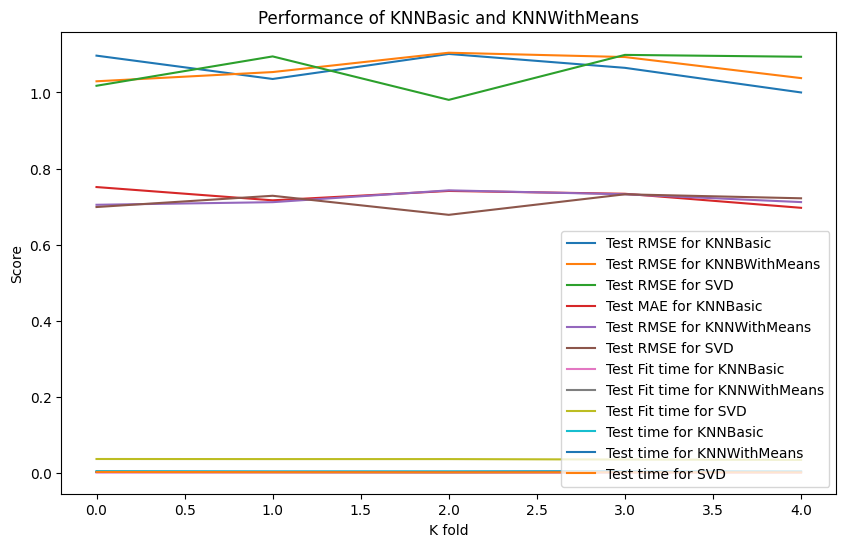

In [8]:
metrics_list = []
for algo in algos:
    metrics = cross_validate(algo, dataset)
    metrics['mean_test_rmse'] = np.mean(metrics['test_rmse'])
    metrics['mean_test_mae'] = np.mean(metrics['test_mae'])
    metrics_list.append(metrics)

k = range(0,5)
plt.figure(figsize=(10, 6))
plt.plot(k, metrics_list[0]['test_rmse'], label='Test RMSE for KNNBasic')
plt.plot(k, metrics_list[1]['test_rmse'], label='Test RMSE for KNNBWithMeans')
plt.plot(k, metrics_list[2]['test_rmse'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['test_mae'], label='Test MAE for KNNBasic')
plt.plot(k, metrics_list[1]['test_mae'], label='Test RMSE for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_mae'], label='Test RMSE for SVD')
plt.plot(k, metrics_list[0]['fit_time'], label='Test Fit time for KNNBasic')
plt.plot(k, metrics_list[1]['fit_time'], label='Test Fit time for KNNWithMeans')
plt.plot(k, metrics_list[2]['fit_time'], label='Test Fit time for SVD')
plt.plot(k, metrics_list[0]['test_time'], label='Test time for KNNBasic')
plt.plot(k, metrics_list[1]['test_time'], label='Test time for KNNWithMeans')
plt.plot(k, metrics_list[2]['test_time'], label='Test time for SVD')
plt.xlabel("K fold")
plt.ylabel("Score")
plt.legend(loc='lower right')
plt.title("Performance of KNNBasic and KNNWithMeans")
plt.show()

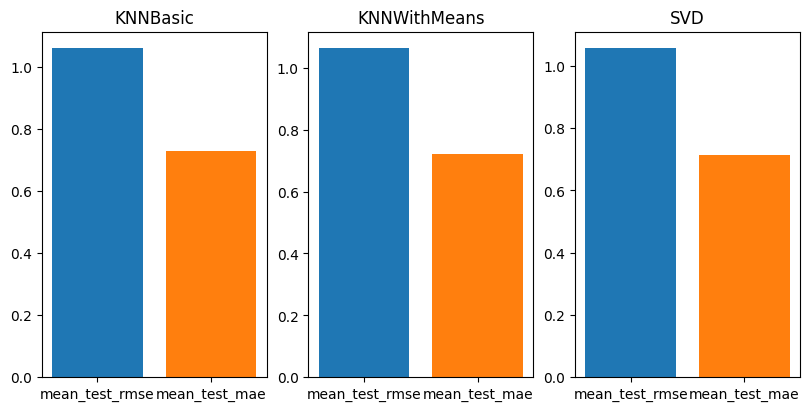

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in metrics_list:
    for k in m:
        if 'mean' in k:
            axes[ind].bar(k, m[k])
            axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Precision and Recall

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/precision_recall_at_k.py

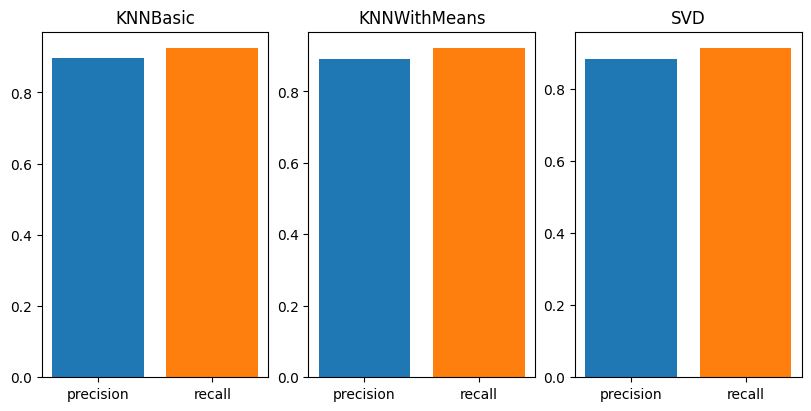

In [10]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    return precisions, recalls
kf = KFold(n_splits=5)

algo_res = []
for algo in algos:
    res_dict = {'precision': [], 'recall': []}
    for trainset, testset in kf.split(dataset):
        algo.fit(trainset)
        predictions = algo.test(testset)
        precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=4)
        res_dict['precision'].append(sum(prec for prec in precisions.values()) / len(precisions))
        res_dict['recall'].append(sum(rec for rec in recalls.values()) / len(recalls))
    algo_res.append(res_dict)


fig, axes = plt.subplots(1, 3, figsize=(8,4), layout='constrained')
method = ["KNNBasic", "KNNWithMeans", "SVD"]
ind = 0
for m in algo_res:
    for k in m:
        axes[ind].bar(k, m[k])
        axes[ind].set_title(method[ind])
    ind += 1
plt.show()

### Get TopN Recommendations For All Users

Taken from https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py

In [11]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n
testset = trainset.build_anti_testset()
predictions = algos[2].test(testset)
top_n = get_top_n(predictions, n=10)
recommendations = {}
for uid, user_ratings in top_n.items():
    recommendations[uid] = [iid for (iid, _) in user_ratings]

### Pick out users and explore their history and recommendations

In [12]:
def get_random_users(lst, n):
    rand_ids = random.choices(lst, k=n)
    return rand_ids


def get_ilocs(df_utility, userids):
    userids_ilocs = []
    original_indices = df_utility.index
    for u in userids:
        userids_ilocs.append(original_indices.get_loc(u))
    return userids_ilocs


userids = get_random_users(list(recommendations.keys()), len(list(recommendations.keys())))
userids_ilocs = get_ilocs(df_utility, userids)
for user_id in userids:
    #print(f"user history: {user_id}")
    #display(reviews_df.loc[[user_id]][['ProductName', 'customerReview']])
    reco_list = recommendations[user_id]
    #print("recommended items")
    #display(asins_df.loc[reco_list])
    #print('\n')

## Latent-factor based Collaborative Filtering

### ALS

100%|██████████| 409/409 [00:00<00:00, 2336.12it/s]


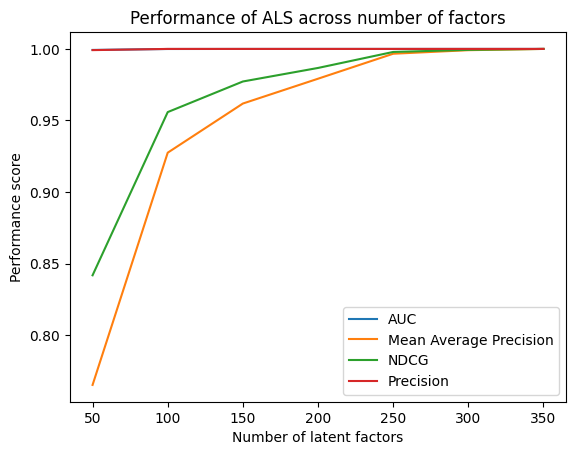

In [13]:
csr_utility = scipy.sparse.csr_matrix(df_utility.fillna(0).values)
!export OPENBLAS_NUM_THREADS=1
threadpoolctl.threadpool_limits(1, "blas")

auc_list = []
mean_ave_precision_list = []
ndcg_list = []
precision_list = []

factors = [50, 100, 150, 200, 250, 300,
           350]

for factor in factors:
    model = ALS(
        factors=factor,
        regularization=0.05,
        alpha=1.5,
        use_cg=True,
        iterations=20,
        random_state=143
    )
    model.fit(csr_utility, show_progress=False)

    # evaluation
    training_set, test_set = train_test_split(
        csr_utility,
        train_percentage=0.85,
        random_state=143
    )
    auc = AUC_at_k(model,training_set,test_set,
                K=len(df_utility), show_progress=True)
    mean_ave_precision = mean_average_precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    ndcg = ndcg_at_k(model, training_set, test_set,
                K=len(df_utility), show_progress=True)
    precision = precision_at_k(model, training_set,
                test_set, K=len(df_utility), show_progress=True)
    auc_list.append(auc)
    mean_ave_precision_list.append(mean_ave_precision)
    ndcg_list.append(ndcg)
    precision_list.append(precision)

plt.plot(factors, auc_list, label='AUC')
plt.plot(factors, mean_ave_precision_list, label='Mean Average Precision')
plt.plot(factors, ndcg_list, label='NDCG')
plt.plot(factors, precision_list, label='Precision')
plt.xlabel('Number of latent factors')
plt.ylabel('Performance score')
plt.title("Performance of ALS across number of factors")
plt.legend()
plt.show()

Select `factors=250`

In [14]:
model = ALS(
    factors=250,
    regularization=0.05,
    alpha=1.5,
    calculate_training_loss=False,
    use_cg=True,
    iterations=20,
    random_state=143
)
model.fit(csr_utility, show_progress=False)

ids, scores = model.recommend(userids_ilocs, csr_utility[userids_ilocs])
recommendations = [(x, y, z) for x, y, z in zip(userids_ilocs, ids, scores)]

def show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility):
    """
    Display user purchase history and recommendations
    """
    for user_ind, reco_ids, scores in recommendations:
        reviewer_id = df_utility.iloc[user_ind, :].name
        #print(f"user history: {reviewer_id}")
        #display(reviews_df.loc[reviewer_id].drop([
        #    "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        #], axis=1))
        #print("recommendations")
        inds = df_utility.columns[reco_ids]
        df_reco = asins_df.loc[inds]
        df_reco['score'] = scores
        #display(df_reco)
        
show_user_history_and_recos_als(recommendations, reviews_df, asins_df, df_utility)

## Content-based Recommender Systems

* Basic content-based recommender system using numerical user profile aggregation. Try cosine, euclidean, and jaccard distance metrics
* Hybrid recommender using LightFM

We first use a basic content-based recommender system that relies on aggregating the numeric user profile and various distance metrics such as cosine, euclidean, and jaccard. Then, we compare the results to a Hybrid Recommender System as provided by the LightFM library.

### Content-Based Recommender

* Use numerical user profile aggregation
* Try different distance metrics such as cosine, euclidean, and Jaccard distance

In [15]:
def get_user_profile(reviewerID, df_utility, items_df):
    """
    Return series representing aggregated user profile
    """
    user_ratings = df_utility.loc[reviewerID]
    user_ratings_nonnan = user_ratings[user_ratings.notnull()]
    user_ratings_nonnan = user_ratings_nonnan[user_ratings_nonnan != 0]
    mean = np.mean(user_ratings_nonnan)
    mean_centered_user_ratings = user_ratings_nonnan - mean
    nonnan_asins = mean_centered_user_ratings.index.tolist()
    dotprod = np.dot(mean_centered_user_ratings, items_df.loc[nonnan_asins])
    return dotprod, nonnan_asins


def get_recommendations(user_profile, items_df,
        n, user_history, eval, dist):
    """
    Return dictionary of sorted recommendations
    """
    if dist == 'cos':
        dist_func = distance.cosine
    if dist == 'euc':
        dist_func = distance.euclidean
    if dist == 'jac':
        dist_func = distance.jaccard
    similarities = {}
    for ind, feats in items_df.iterrows():
        if ind not in user_history:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
        if eval:
            similarities[ind] = np.abs(dist_func(feats, user_profile))
    sorted_similarites = dict(sorted(
        similarities.items(), key=lambda item: item[1], reverse=False)[:n])
    normalized_scores = normalize_ratings(pd.Series(sorted_similarites.values()))
    for key, value in zip(sorted_similarites.keys(), normalized_scores):
        sorted_similarites[key] = value
    return sorted_similarites


def normalize_ratings(recommendations):
    """
    Return mapped ratings. We do this because the scoring
    for user_history and recommendations are in different ranges 
    """
    return (
        recommendations - recommendations.min()) / (
            recommendations.max() - recommendations.min()) * (0 - 5) + 5


def dcg(user_history, recommendations):
    """
    Return dcg for this user given their history
    and recommendations
    """
    ranking = 1
    dcg_final = 0
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    for key, value in recommendations.items():
        dcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return dcg_final / len(recommendations)


def idcg(user_history, recommendations):
    """
    Return ndcg for this user given their history
    and recommendations
    """
    actual_ratings = user_history.reset_index()[
        ['ASIN', 'customerReview']].set_index('ASIN').to_dict()['customerReview']
    ranking = 1
    idcg_final = 0
    for key in actual_ratings.keys():
        idcg_final += ((2**actual_ratings[key]) - 1) / log(ranking + 1)
        ranking += 1
    return idcg_final / len(recommendations)


def basic_content_based_recommender(
    userids, df_utility, items_df,
    reviews_df, asins_df, n, eval, dist):
    """
    Return recommendations for the list of users.

    Parameters:
    userids: STRING list
    df_utility: DataFrame representing the utility matrix
    items_df: DataFrame representing the itemset
    reviews_df: DataFrame representing user history
    asins_df: DataFrame that contains mapping between ASINs and Product Names
    n: INTEGER Number of recommendations to output
    dist: STRING distance function to be used
    """
    recommendations = {}
    ndcg = None
    if eval:
        dcg_list = []
        idcg_list = []
        ndcg_list = []
    for user in userids:
        user_profile, nonnan_asins = get_user_profile(user, df_utility, items_df)
        user_history_df = reviews_df.loc[user].drop([
            "Unnamed: 0", "reviewDate", "reviewLocation", "reviewVotes"
        ], axis=1)
        user_history_df = user_history_df.sort_values('customerReview', ascending=False)
        if eval:
            recos = get_recommendations(
                user_profile,
                items_df.loc[nonnan_asins],
                len(user_profile),
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
            dcg_list.append(dcg(user_history_df, recos))
            idcg_list.append(idcg(user_history_df, recos))
        else:
            recos = get_recommendations(
                user_profile,
                items_df,
                n,
                reviews_df.loc[user]['ASIN'].tolist(),
                eval,
                dist
            )
        recommendations[user] = recos
        #print(f"sorted user history: {user}")
        #display(user_history_df)
        #print(f"recommended items")
        df_reco = asins_df.loc[list(recos.keys())]
        df_reco['normalized_relevance_score'] = pd.Series(recommendations[user])
        #display(df_reco)
    if eval:
        dcg_final = np.mean(dcg_list)
        idcg_final = np.mean(idcg_list)
        ndcg = dcg_final / idcg_final
        ndcg_list.append(ndcg)
        #print(f"ndcg for this user is given by: {ndcg}")
    return recommendations, ndcg_list

## Evaluation: NDCG @ K=10

Get average NDCG across all users. Compare NDCG across different distance metrics.

In [16]:
dist_config = ['euc', 'cos', 'jac']
df_utility.fillna(0, inplace=True)
items_df.fillna(0, inplace=True)
np.seterr(invalid='ignore')
for d in dist_config:
    recommendations, ndcg_list = basic_content_based_recommender(
        userids, df_utility, items_df.copy(),
        reviews_df, asins_df, 10, True, d)
    print(f"average ndcg with distance metric {d} is {np.mean(ndcg_list)}")

average ndcg with distance metric euc is 0.9627076231385068
average ndcg with distance metric cos is 0.9842677557249345
average ndcg with distance metric jac is 0.9476806094657313


## Hybrid Recommender Using LightFM

A hybrid latent representation recommender model.

The model learns embeddings (latent representations in a high-dimensional space) for users and items in a way that encodes user preferences over items. When multiplied together, these representations produce scores for every item for a given user; items scored highly are more likely to be interesting to the user.

### LightFM Training Model

- Logistic: useful when both positive (1) and negative (-1) interactions are present.
- BPR: Bayesian Personalised Ranking 1 pairwise loss. Maximises the prediction difference between a positive example and a randomly chosen negative example. Useful when only positive interactions are present and optimising ROC AUC is desired.
- WARP: Weighted Approximate-Rank Pairwise 2 loss. Maximises the rank of positive examples by repeatedly sampling negative examples until rank violating one is found. Useful when only positive interactions are present and optimising the top of the recommendation list (precision@k) is desired.
- k-OS WARP: k-th order statistic loss 3. A modification of WARP that uses the k-th positive example for any given user as a basis for pairwise updates.

In [25]:
top_100_df = df_utility.head(10_000)
melted_user_df_top_100 = top_100_df.reset_index().melt(
    'reviewerID', var_name='ASIN', value_name='rating').dropna()

reviewers_to_remove = [
    'Amazon CustomerAmazon Customer_',
    'Amazon Customer_',
    'Cliente de Amazon_',
    'Cliente Amazon_',
    'Kindle Customer_',
    'Client d\'Amazon_',
    'Amazon Customer',
    'Amazon Customer_',
    'Amazon Kunde_',
    'Amazon カスタマー_',
    'Cliente Kindle_',
    'Cliente de Kindle_'
]

udf_top_100 = melted_user_df_top_100[~melted_user_df_top_100['reviewerID'].isin(reviewers_to_remove)]

In [26]:
# Create a dataset object
dataset = Dataset()
dataset.fit(users=udf_top_100['reviewerID'].unique(),
            items=udf_top_100['ASIN'].unique())

# Build the interactions matrix
(interactions, _) = dataset.build_interactions(zip(udf_top_100['reviewerID'], 
                                                   udf_top_100['ASIN'],
                                                   udf_top_100['rating']))

TypeError: Dataset.__init__() missing 1 required positional argument: 'reader'

In [ ]:
Train, Test = random_train_test_split(interactions, test_percentage=0.2, random_state=42)
model = LightFM(loss='warp', no_components=30)
model.fit(Train, epochs=30, num_threads=2)

In [ ]:
auc_scores = []
precision_scores = []
recall_scores = []

k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Train"):
    auc = auc_score(model, Train, ).mean()
    precision = precision_at_k(model, Train, k=k).mean()
    recall = recall_at_k(model, Train, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Train Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

In [ ]:
k_values = range(1, 11)
auc_scores = []
precision_scores = []
recall_scores = []

for k in tqdm(k_values, desc="Processing Test"):
    auc = auc_score(model, Test).mean()
    precision = precision_at_k(model, Test, k=k).mean()
    recall = recall_at_k(model, Test, k=k).mean()
    
    auc_scores.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)

print("Test Results:")
for k, auc, precision, recall in zip(k_values, auc_scores, precision_scores, recall_scores):
    print(f'K = {k}: AUC score: {auc}, Precision: {precision}, Recall: {recall}')

In [ ]:
def get_top_n_recommendations_with_latest_transactions(model, dataset, user_id, transactions_df, n=10):

    # Generate predictions for all items for this user
    user_index = dataset.mapping()[0][user_id]
    
    # Retrieve the actual item indices from the dataset mapping
    item_indices = list(dataset.mapping()[2].values())  # This ensures you're using the correct item indices
    
    # Generate predictions using the correct item indices
    scores = model.predict(user_index, np.array(item_indices))
    
    # Map scores to item IDs
    reverse_item_map = {v: k for k, v in dataset.mapping()[2].items()}
    scored_items = [(score, reverse_item_map[i]) for score, i in zip(scores, item_indices)]
    
    # Proceed with filtering scores for latest items and ranking them as before
    latest_transactions = transactions_df[transactions_df['reviewerID'] == user_id]\
                            .sort_values('reviewDate', ascending=False)\
                            .head(10)
    latest_items = set(latest_transactions['ASIN'])
    latest_scores = [score for score in scored_items if score[1] in latest_items]
    latest_scores.sort(reverse=True, key=lambda x: x[0])  # Sort based on scores
    top_item_ids = [item for _, item in latest_scores[:n]]

    return top_item_ids


In [ ]:
uid = 'Laura_'

# Filter the DataFrame for the given reviewerID and select relevant columns
print(f"Top 10 Latest Reviews by {uid}")
reviewer_reviews_df = reviews_df[reviews_df['reviewerID'] == uid][['ASIN','ProductName','reviewRating','reviewDate']]
reviewer_reviews_df.sort_values(by='reviewDate', ascending=False).head(10)

In [ ]:
top_recommendations = get_top_n_recommendations_with_latest_transactions(model, dataset, user_id=uid, n=10)
recommended_products_df = reviews_df[reviews_df['ASIN'].isin(top_recommendations)].drop_duplicates(subset=['ASIN'])
recommended_products_names = recommended_products_df[['ASIN', 'ProductName', 'reviewRating']].drop_duplicates()
print(f'Top-N Recommendations for {uid} based on All Transactions')
recommended_products_names

### Interpretation of Results

- The AUC score is consistently high (0.9986754059791565) across all K values, indicating excellent overall model performance in distinguishing between positive and negative interactions.

- Precision at K measures the proportion of recommended items in the top-K set that are relevant. Precision decreases as K increases in your results, which is expected. When you recommend more items (increase K), the likelihood of including irrelevant items increases, thus lowering precision. However, a precision above 0.08 even at K=10 is quite good, suggesting that the top recommended items are largely relevant.

- Recall at K measures the proportion of relevant items that are successfully recommended in the top-K set. Your results show increasing recall with K, which is typical. As you recommend more items, you're more likely to cover a higher fraction of the relevant items, hence the recall increases. A recall of 0.8549128186215507 at K=10 indicates that about 85% of the relevant items are captured in the top 10 recommendations.

## Build Pickle File For Streamlit Application

In [22]:
non_nan_count = df_utility.notna().sum(axis=1)
df_top_reviewers = df_utility.loc[non_nan_count.sort_values(ascending=False).index].iloc[:20]

#### Export User History and Recommendations as Pickle file

In [21]:
user_hist_reco_dict={}
for algo in algos:
    algo_name = algo.__class__.__name__
    user_hist_reco_dict[algo_name] = {}
    predictions = algo.test(testset)
    top_n = get_top_n(predictions, n=10)
    recommendations = {}
    for uid, user_ratings in top_n.items():
        recommendations[uid] = [iid for (iid, _) in user_ratings]    
    for user, row in df_top_reviewers.iterrows():
        df_user_hist = reviews_df.loc[[user]][['ASIN','ProductName', 'customerReview']]
        reco_list = recommendations[user]
        df_reco = asins_df.loc[reco_list]
        # Add the tuple (reviews_subset, df_reco) to the dictionary with reviewer_id as the key
        user_hist_reco_dict[algo_name][user] = (df_user_hist, df_reco)
display(user_hist_reco_dict)   
# Save the dictionary to a pickle file
pd.to_pickle(user_hist_reco_dict, 'user_hist_reco.pkl')

{'KNNBasic': {'***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ': (                                                        ASIN  \
   reviewerID                                                     
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0cjd7f96w   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0bzz41652   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0c8b699vd   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0c7k4r4mt   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0bzz41652   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b08yr944y4   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0c8bcvx3w   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0cnh9t9ll   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0c8h586sj   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b09kmhdwnf   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0cgq7wrv7   
   ***Toy Collector***_AG5NFKDKQNEYV76GKH7BMXNTHKSQ  b0c7nfsxjg  